# <font color='darkblue'>Time Series Forecasting & Sentiment Analytics</font>
## <font color='darkblue'>Modelo Preditivo de Preços de Ações</font>
### <font color='black'>By Fran Mateus</font>

# <font color='red'>Business goal</font>
Make predictions for stock prices using both their daily prices, as well as dozens of news stories published in the media about such prices, to identify their impact on future daily predictions.

# <font color='red'>Part 1</font>

## <font color='orangered'>Libraries</font>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
#from pandas_datareader.data import DataReader
from datetime import datetime

#from statsmodels.tsa.arima_model import ARIMA
#from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima
#from statsmodels.tsa.statespace.sarimax import SARIMAX

## <font color='orangered'>Datasets</font>

In [2]:
df_acoes_cols = pd.read_csv("dados/stemp_dfnumerico.csv")[["Date", "Close"]]
df_acoes_cols.head(2)

,Date,Close
0,2005-01-03,6679.200195
1,2005-01-04,6651.009766


In [3]:
df_score = pd.read_csv("dados/text_score_sentiment.csv")
df_score.drop("News", axis=1, inplace=True)
df_score.head(2)

,Date,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,2001-01-03,0.392857,0.089286,-0.8910,0.156,0.735,0.109


In [4]:
# Concatenando datasets
df_merge = pd.merge(df_acoes_cols, df_score, how = 'inner', on = 'Date').drop("Date", axis=1)
df_merge.head(2)

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,6679.200195,0.398414,0.066700,-0.9972,0.190,0.696,0.114
1,6651.009766,0.374999,0.071855,-0.9516,0.095,0.837,0.068


In [5]:
df_merge.describe()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
count,3655.000000,3655.000000,3655.000000,3655.000000,3655.000000,3655.000000,3655.000000
mean,21124.125256,0.401256,0.068954,-0.928374,0.156445,0.739663,0.103899
std,8733.757649,0.027178,0.030924,0.344588,0.022698,0.028042,0.016581
min,6102.740234,0.256633,-0.058792,-1.000000,0.073000,0.578000,0.047000
25%,15149.320312,0.384125,0.049090,-0.999900,0.143000,0.722000,0.093000
50%,19016.460938,0.400588,0.067634,-0.999800,0.157000,0.738000,0.103000
75%,27579.464844,0.417376,0.086548,-0.998900,0.171000,0.755000,0.114000
max,41130.171875,0.551223,0.294776,0.999900,0.263000,0.870000,0.230000


In [6]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3655 entries, 0 to 3654
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         3655 non-null   float64
 1   Subjectivity  3655 non-null   float64
 2   Polarity      3655 non-null   float64
 3   Compound      3655 non-null   float64
 4   Negative      3655 non-null   float64
 5   Neutral       3655 non-null   float64
 6   Positive      3655 non-null   float64
dtypes: float64(7)
memory usage: 228.4 KB


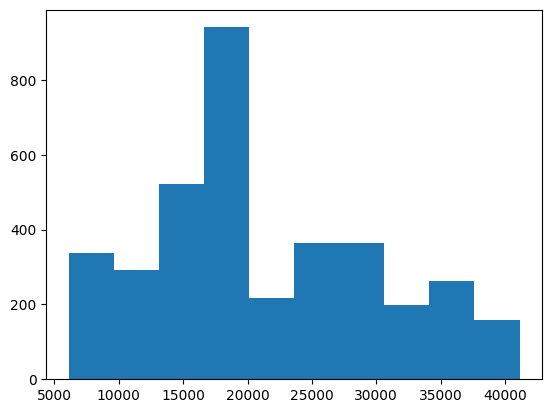

In [7]:
# Histograma
plt.hist(df_merge[['Close']], histtype = 'stepfilled', rwidth = 0.9)
plt.show()

# <font color='red'>Part 2: Data Preparation</font>

Os dados usandos neste trabalho já passaram pela análise de decomposição e estacionariedade e já foram limpos e tratados.

In [8]:
# Proporção de dados para treino e teste
train_size = int(len(df_merge) * 0.80)
test_size = len(df_merge) - train_size
dados_treino, dados_teste = df_merge.iloc[0:train_size], df_merge.iloc[train_size:len(df_merge)]

In [9]:
# Variável alvo
treino = dados_treino["Close"]
teste = dados_teste["Close"]

In [10]:
print(treino.shape), print(teste.shape)

(2924,)
(731,)


(None, None)

In [11]:
# Aplica transformação de log
dados_treino_log = np.log(treino) 
dados_teste_log = np.log(teste)

# <font color='red'>Part 3: Data Modeling with ARIMA</font>

## <font color='blue'>v1 - ARIMA sem variáveis exógenas</font>

In [12]:
%%time
model1 = auto_arima(dados_treino_log)
model1

Wall time: 15.8 s


ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True)

In [13]:
prediction1 = model1.predict(n_periods = len(dados_teste_log))

In [14]:
# Retorna a escala original dos dados
outcome1 = np.exp(prediction1)

In [15]:
previsoes_auto1 = pd.DataFrame(outcome1.values, index = teste.index, columns = ['Predição'])

## <font color='blue'>v2 - ARIMA com todas variáveis exógenas</font>

In [16]:
# Variáveis exógenas
exog_train_data = dados_treino[["Subjectivity", "Polarity", "Compound", "Negative", "Neutral", "Positive"]]
exog_test_data = dados_teste[["Subjectivity", "Polarity", "Compound", "Negative", "Neutral", "Positive"]]

In [17]:
print(exog_train_data.shape), print(exog_test_data.shape)

(2924, 6)
(731, 6)


(None, None)

In [18]:
%%time
model2 = auto_arima(dados_treino_log, X=exog_train_data)
model2

Wall time: 1min


ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True)

In [19]:
prediction2 = model2.predict(n_periods = len(dados_teste_log), X = exog_test_data)

In [20]:
outcome2 = np.exp(prediction2)

In [21]:
previsoes_auto2 = pd.DataFrame(outcome2.values, index = teste.index, columns = ['Predição'])

## <font color='blue'>v3 - ARIMA com as variáveis "Subjectivity", "Polarity" e "Compound"</font>

In [22]:
exog_train_data_b = dados_treino[["Subjectivity", "Polarity", "Compound"]]
exog_test_data_b = dados_teste[["Subjectivity", "Polarity", "Compound"]]

In [23]:
%%time
model3 = auto_arima(dados_treino_log, X=exog_train_data_b)
model3

Wall time: 34.7 s


ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True)

In [24]:
prediction3 = model3.predict(n_periods = len(dados_teste_log), X = exog_test_data_b)

In [25]:
outcome3 = np.exp(prediction3)

In [26]:
previsoes_auto3 = pd.DataFrame(outcome3.values, index = teste.index, columns = ['Predição'])

## <font color='blue'>v4 - ARIMA com "Subjectivity", "Polarity", "Negative" e "Positive"</font>

In [27]:
# Variáveis exógenas
exog_train_data_c = dados_treino[["Subjectivity", "Polarity", "Negative", "Positive"]]
exog_test_data_c = dados_teste[["Subjectivity", "Polarity", "Negative", "Positive"]]

In [28]:
%%time
model4 = auto_arima(dados_treino_log, X=exog_train_data_c)
model4

Wall time: 41.3 s


ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True)

In [29]:
prediction4 = model4.predict(n_periods = len(dados_teste_log), X = exog_test_data_c)

In [30]:
outcome4 = np.exp(prediction4)

In [31]:
previsoes_auto4 = pd.DataFrame(outcome4.values, index = teste.index, columns = ['Predição'])

## <font color='blue'>v5 - ARIMA apenas com "Negative" e "Positive"</font>

In [32]:
# Variáveis exógenas
exog_train_data_d = dados_treino[["Negative", "Positive"]]
exog_test_data_d = dados_teste[["Negative", "Positive"]]

In [33]:
%%time
model5 = auto_arima(dados_treino_log, X=exog_train_data_d)
model5

Wall time: 20.5 s


ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True)

In [34]:
prediction5 = model5.predict(n_periods = len(dados_teste_log), X = exog_test_data_d)

In [35]:
outcome5 = np.exp(prediction5)

In [36]:
previsoes_auto5 = pd.DataFrame(outcome5.values, index = teste.index, columns = ['Predição'])

## <font color='blue'>v6 - ARIMA com "Negative", "Positive" e "Neutral"</font>

In [37]:
# Variáveis exógenas
exog_train_data_e = dados_treino[["Negative", "Positive", "Neutral"]]
exog_test_data_e = dados_teste[["Negative", "Positive", "Neutral"]]

In [38]:
%%time
model6 = auto_arima(dados_treino_log, X=exog_train_data_e)
model6

Wall time: 19.3 s


ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True)

In [39]:
prediction6 = model6.predict(n_periods = len(dados_teste_log), X = exog_test_data_e)

In [40]:
outcome6 = np.exp(prediction6)

In [41]:
previsoes_auto6 = pd.DataFrame(outcome6.values, index = teste.index, columns = ['Predição'])

# <font color='red'>Part 4: Models Evaluation</font>

In [42]:
# MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [43]:
# COMPARATIVO MODELOS
print("Evaluation by AIC")
print('AIC: ARIMA v1 = ', model1.aic())
print('AIC: ARIMA v2 = ', model2.aic())
print('AIC: ARIMA v3 = ', model3.aic())
print('AIC: ARIMA v4 = ', model4.aic())
print('AIC: ARIMA v5 = ', model5.aic())
print('AIC: ARIMA v6 = ', model6.aic())

print("---------------------------------------------------")
print("Evaluation by RMSE")
print('RMSE: ARIMA v1 = ', mean_squared_error(teste, outcome1, squared = False))
print('RMSE: ARIMA v2 = ', mean_squared_error(teste, outcome2, squared = False))
print('RMSE: ARIMA v3 = ', mean_squared_error(teste, outcome3, squared = False))
print('RMSE: ARIMA v4 = ', mean_squared_error(teste, outcome4, squared = False))
print('RMSE: ARIMA v5 = ', mean_squared_error(teste, outcome5, squared = False))
print('RMSE: ARIMA v6 = ', mean_squared_error(teste, outcome6, squared = False))

print("---------------------------------------------------")
print("Evaluation by MAPE")
print('MAPE: ARIMA v1 = ', MAPE(teste, outcome1))
print('MAPE: ARIMA v2 = ', MAPE(teste, outcome2))
print('MAPE: ARIMA v3 = ', MAPE(teste, outcome3))
print('MAPE: ARIMA v4 = ', MAPE(teste, outcome4))
print('MAPE: ARIMA v5 = ', MAPE(teste, outcome5))
print('MAPE: ARIMA v6 = ', MAPE(teste, outcome6))

Evaluation by AIC
AIC: ARIMA v1 =  -16271.723794704998
AIC: ARIMA v2 =  -16264.401587408223
AIC: ARIMA v3 =  -16267.362647900241
AIC: ARIMA v4 =  -16267.84268725069
AIC: ARIMA v5 =  -16270.4589811953
AIC: ARIMA v6 =  -16268.889912353232
---------------------------------------------------
Evaluation by RMSE
RMSE: ARIMA v1 =  3580.4647767771153
RMSE: ARIMA v2 =  3554.2219817242526
RMSE: ARIMA v3 =  3545.2475968698786
RMSE: ARIMA v4 =  3588.848393815709
RMSE: ARIMA v5 =  3588.8492899007533
RMSE: ARIMA v6 =  3591.0506646215745
---------------------------------------------------
Evaluation by MAPE
MAPE: ARIMA v1 =  9.47061603262442
MAPE: ARIMA v2 =  9.396841493188145
MAPE: ARIMA v3 =  9.37010190301449
MAPE: ARIMA v4 =  9.495312259430893
MAPE: ARIMA v5 =  9.495077219460523
MAPE: ARIMA v6 =  9.501435700655232


# <font color='red'>Part 5: Conclusões</font>

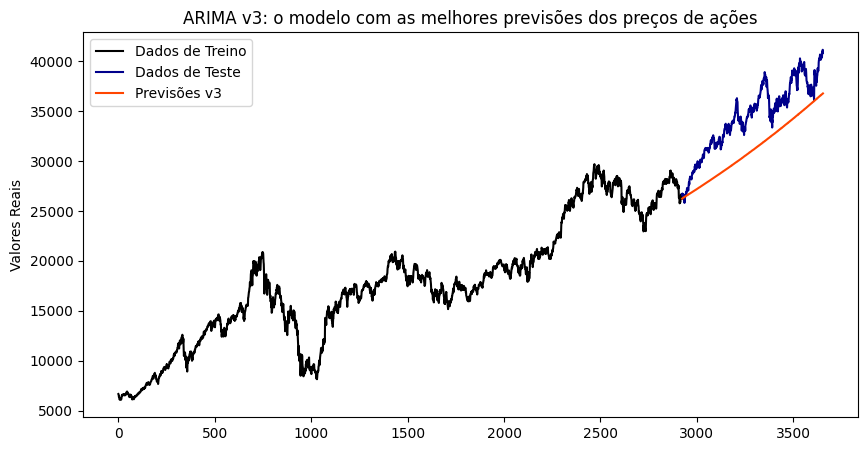

In [45]:
# Plot outcomes
plt.figure(figsize = (10,6))
plt.plot(treino, label = 'Dados de Treino', color='black')
plt.plot(teste, label = 'Dados de Teste', color = 'darkblue')
plt.plot(previsoes_auto3, label = 'Previsões v3', color = 'orangered')
plt.title('ARIMA v3: o modelo com as melhores previsões dos preços de ações')
plt.ylabel('Valores Reais')
plt.legend()

- Primeiro, o modelo sem as variáveis exógenas apresentou os piores resultados em termos de RMSE e MAPE. Logo, para esse conjunto de dados, foi uma boa estratégia incluir as variáveis que captam sentimentos através da análise textual.
- Segundo, escolher o modelo consderando somente o AIC pode não ser a melhor opção para se obter a melhor performance através do ARIMA, visto que o modelo com os menores valores de erros não é, necessariamente, o de melhor resultado AIC.
- Terceiro, incluir todas as variáveis exógenas não garante resultados melhores. No caso analisado, usando somente as variáveis "Subjectivity", "Polarity" e "Compound" foi possível ter a melhor estimativa de previsão futura (dados de testes vs. previsões v3).
- Por fim, todos os modelos captaram a tendência do preço das ações (linha laranja no gráfico), mas não as suas oscilações cíclicas. Será preciso analisar os mesmos dados com outras técnicas, por exemplo, SARIMAX, Prophet, Transformers.